# Tickets vs warnings with the Boston Globe

In 2003 and 2004, the Boston Globe published a series called [Speed Trap: Who Gets a Ticket, Who Gets a Break?](http://archive.boston.com/globe/metro/packages/tickets/). Using speeding data from Massachusetts, we'll reproduce some segments of this analysis using logistic regression.

<p class="reading-options">
  <a class="btn" href="/boston-globe-tickets/boston-globe-ticketing-regression">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/boston-globe-tickets/notebooks/Boston Globe ticketing regression.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="#">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **tickets-warnings.csv:** ticketing data - TODO


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/boston-globe-tickets/data/tickets-warnings.csv.zip -P data
!unzip -n -d data data/tickets-warnings.csv.zip

This piece was brought to my attention by Jonathan Stray, who put together [the notebook this section is based on](https://github.com/jstray/lede-algorithms/blob/master/week-3/week-3-2-class.ipynb). As to what's special about this project, let's just go right to the source:

> Why such old data? Well, for one thing it's a classic example of multi-variable regression in journalism. But also, for a brief period of April and May 2001, the state government entered both tickets and warnings from the paper citations. In Massechusets at that time, both were written on the same form, with only a checkbox indicating which it was. A ticket means a fine and a raises your insurance premium. A warning means nothing. Having data on both means we can ask who gets a ticket vs. a warning for the same circumstances.

Generally ticketing data just says who got a ticket, full stop. The fact that we have a yes/no column - ticketed/warned - makes this dataset ripe for **logistic regression**.

We can find The Boston Globe's [full methodology here](http://archive.boston.com/globe/metro/packages/tickets/study.pdf). It's a great document, full of tables and details and even a link at the bottom to download the original dataset (the link is broken now, but hey, it's over 15 years later).

Using this large dataset, the Globe attempted to control for different variables by finding drivers who fit into the same buckets, then comparing their outcomes:

> The Globe relied primarily on comparisons of carefully controlled groups of drivers. For example, how
many drivers who lived in a town received a ticket, and how many received a warning, when speeding at the same
speed, in the same speed zone?

Not fully satisfied with that approach, they also reached out to a statistician for further analysis. She performed a logistic regression, same as what we've been doing:

> To be confident that no other factor, or combination of factors, recorded on the citations accounted for the
differences (such as age, sex, time of day), the Globe asked a professor of statistics at Babson College, Elaine I.
Allen, to look at the database. She found that the differences of race, sex and age were statistically significant,
controlling for all other factors. The report on her analysis, using a statistical technique called logistic regression, is also printed in full below.

Let's get to work!

## Our data

We'll pull in pandas, statsmodels for the regression, and numpy for computing odds ratios

In [2]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)

Then we'll pull in our data. Unknown data is coded as `U`, so we'll just pass that to `na_values` to be missing data.

In [3]:
# Unknown data is always coded as 'U', so we'll pass that to na_values
df = pd.read_csv('data/tickets-warnings.csv', na_values='U')
df.head()

,TYPE,CITATION,DATE,DOW,AGENCY,AGENCY2,AGENCY3,LOCAL,OFFICER,LICSTATE,CLASS,CDL,RACE,MINORITY,BLACK,ASIAN,HISPANIC,MIDDLE,NATIVE,SEX,FEMALE,SEARCH,SEARCH2,LOCATE2,LOCATION,TIME,AMPM,TIEMDAY,DAYNIGHT,DAY,DESCRIPT,AMOUNT,MPH,ZONE,MPHOVER,MPHPCT,MPHGROUP,YOB,AGE,AGEGROUP,AGEBAND,ZIP,NEIGHBOR,INNEIGH,REGSTATE,V_MAKE,V_TYPE,V_YEAR,V_AGE,V_AGEGRP,COLOR,HOMESTATE,HOMETOWN,INTOWN,INSTATE,INTOWN2,INSTATE2
0,T,K0001506,20010411,Wednesday,State Police Troop A-4,State Police,S,N,8.247791e+15,MA,D,N,W,W,0.0,0.0,0.0,0.0,0.0,M,0.0,NaN,NaN,Woburn,Woburn,5,PM,b) afternoon,day,1,SPEEDING,125.0,80,65,15.0,23.0,b) 10 to 15,1980,21.0,21-25,16-25,1876.0,NaN,NaN,MA,NaN,NaN,0,NaN,NaN,NaN,MA,Tewksbury,N,Y,0.0,1
1,T,K0001507,20010417,Tuesday,State Police Troop A-4,State Police,S,N,8.247791e+15,MA,D,N,W,W,0.0,0.0,0.0,0.0,0.0,F,1.0,NaN,NaN,Somerville,Somerville,10,AM,a) morning,day,1,TRAFFIC VIOLATION,50.0,0,0,NaN,NaN,NaN,1965,36.0,36-40,26-39,2135.0,Allston-Brighton,N,MA,DODG,ARIES,1988,13.0,older,WHITE,MA,Boston,N,Y,0.0,1
2,T,K0001509,20010420,Friday,State Police Troop A-4,State Police,S,N,8.247791e+15,NH,NaN,N,W,W,0.0,0.0,0.0,0.0,0.0,F,1.0,NaN,NaN,Somerville,Somerville,4,PM,b) afternoon,day,1,FAILURE TO STOP,NaN,0,0,NaN,NaN,NaN,1940,61.0,61-65,40+,3062.0,NaN,NaN,NH,NaN,NaN,0,NaN,NaN,NaN,NH,NaN,N,N,0.0,0
3,T,K0001510,20010420,Friday,State Police Troop A-4,State Police,S,N,8.247791e+15,NH,NaN,N,W,W,0.0,0.0,0.0,0.0,0.0,M,0.0,NaN,NaN,Woburn,Woburn,8,PM,c) evening,night,0,KEEP IN RIGHT LANE,100.0,0,0,NaN,NaN,NaN,1949,52.0,51-55,40+,3045.0,NaN,NaN,NH,NaN,NaN,0,NaN,NaN,NaN,NH,NaN,N,N,0.0,0
4,T,K0001511,20010427,Friday,State Police Troop A-4,State Police,S,N,8.247791e+15,MA,D,N,W,W,0.0,0.0,0.0,0.0,0.0,M,0.0,NaN,NaN,Woburn,Woburn,8,AM,a) morning,day,1,SPEEDING,NaN,85,65,20.0,31.0,c) 16 to 20,1977,24.0,21-25,16-25,1835.0,NaN,NaN,MA,MAZD,B3000,2000,1.0,new,BLACK,MA,Haverhill,N,Y,0.0,1


`TYPE` is the column as to whether they received a ticket or a warning - `T` vs `W` - and most of the other columns are self-explanatory.

It's a lot lot lot of data, but we're only interested in a few columns. Let's take a look at the output of the Globe's regression to see what we should keep.

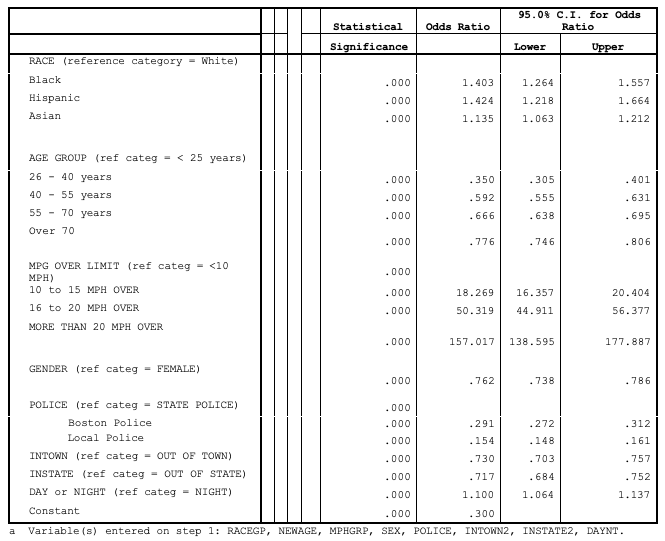

Along with the columns needed for our regression, we're also going to keep `MPH` for a little trick later on.

In [4]:
df = df[['TYPE','AGENCY3','SEX','BLACK','ASIAN','HISPANIC','MINORITY','AGE','MPH','MPHOVER','INTOWN', 'INSTATE', 'DAYNIGHT']].copy()
df.head()

,TYPE,AGENCY3,SEX,BLACK,ASIAN,HISPANIC,MINORITY,AGE,MPH,MPHOVER,INTOWN,INSTATE,DAYNIGHT
0,T,S,M,0.0,0.0,0.0,W,21.0,80,15.0,N,Y,day
1,T,S,F,0.0,0.0,0.0,W,36.0,0,NaN,N,Y,day
2,T,S,F,0.0,0.0,0.0,W,61.0,0,NaN,N,N,day
3,T,S,M,0.0,0.0,0.0,W,52.0,0,NaN,N,N,night
4,T,S,M,0.0,0.0,0.0,W,24.0,85,20.0,N,Y,day


Definitely looks cleaner!

## Non-logistic analysis

When you first start investigating the dataset, you probably (hopefully?) won't leap right to logistic regression. It's useful to poke around a little bit, see what's going on, check whether anything seems wrong or if you can find any interesting leads.

Let's say we have a suspicion that race plays a role in whether someone is ticketed as opposed to just getting a warning. We might start by grouping by `MINORITY` and seeing how many people fall into each ticketing category.

In [6]:
pd.crosstab(df.MINORITY, df.TYPE)

TYPE,T,W
MINORITY,,
M,16072,12636
W,65624,68291


Unfortunately we're terrible at reading numbers and we just _love_ graphics, so we're going to throw a `.plot` on that code to turn it into a chart.

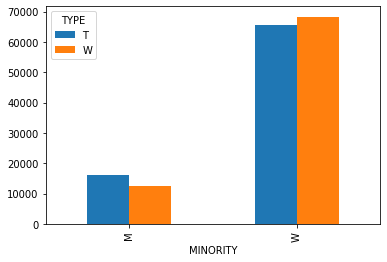

In [8]:
pd.crosstab(df.MINORITY, df.TYPE).plot(kind='bar')

Looks like minorities have fewer tickets and fewer warnings! But that's not too interesting, since there are probably fewer minorities overall. We're probably more interested in the _percentage_ of stops that become a ticket compared to those that are just warnings.

In [12]:
pd.crosstab(df.MINORITY, df.TYPE, normalize='index')

TYPE,T,W
MINORITY,,
M,0.559844,0.440156
W,0.490042,0.509958


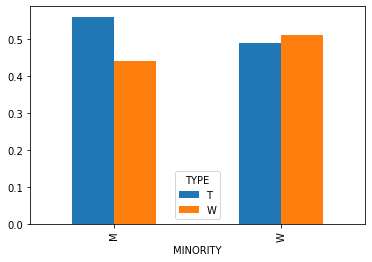

In [15]:
pd.crosstab(df.MINORITY, df.TYPE, normalize='index').plot(kind='bar')

Over half of minorities stopped receive tickets instead of warnings, while it's the opposite for white drivers. A lot of investigations might stop right here, publish a "Minorities more likely to be ticketed when stopped" headline, and call it a day. We can do better!

If we wanted to dig around in the data some more, we could see if it reveals driving differences as logged by the police. Maybe the minoritiy population is disproportionately young, inexperienced drivers, or maybe on average they drive more miles per hour over the speed limit. What we want to know is, **controlling for all other factors, are minorities more likly to be ticketed when stopped?**

When we think "controlling for" a little bell goes off in our heads and we immediately get started on a regression.

## The regression

### Preparing our data

The `TYPE` column - whether the driver received a ticket or not - comes in two options.

* `T` for ticketed
* `W` for warning

These labels are going to be what we're predicting.
 
We've dealt with [categorical variables](/regression/logistic-regression-part-two/#Categorical-variables) before, using `C()` to break each category out into its own feature. **You can't use `C()` to deal with categorical output labels.** When using statsmodels, you'll need to convert this into a number.

To get around this, we'll create a new column called `ticketed`, which will be 1 if the driver received a ticket and 0 if they received a warning.

In [16]:
df['ticketed'] = df.TYPE.replace({'T': 1, 'W': 0})
df.head()

,TYPE,AGENCY3,SEX,BLACK,ASIAN,HISPANIC,MINORITY,AGE,MPH,MPHOVER,INTOWN,INSTATE,DAYNIGHT,ticketed
0,T,S,M,0.0,0.0,0.0,W,21.0,80,15.0,N,Y,day,1
1,T,S,F,0.0,0.0,0.0,W,36.0,0,NaN,N,Y,day,1
2,T,S,F,0.0,0.0,0.0,W,61.0,0,NaN,N,N,day,1
3,T,S,M,0.0,0.0,0.0,W,52.0,0,NaN,N,N,night,1
4,T,S,M,0.0,0.0,0.0,W,24.0,85,20.0,N,Y,day,1


### First regression

Now that our data is prepared, we can perform our regression. Let's start by wrapping each of our categorical variables in `C()` to see how statsmodels does without any guidance.

In [17]:
model = smf.logit("""
    ticketed ~ 
        C(AGENCY3)
        + C(SEX)
        + C(MINORITY)
        + AGE
        + MPHOVER
        + C(INTOWN)
        + C(INSTATE)
        + C(DAYNIGHT)
        """, data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.560816
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ticketed   No. Observations:                89691
Model:                          Logit   Df Residuals:                    89680
Method:                           MLE   Df Model:                           10
Date:                Mon, 30 Dec 2019   Pseudo R-squ.:                  0.1896
Time:                        17:10:50   Log-Likelihood:                -50300.
converged:                       True   LL-Null:                       -62070.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.3659      0.051    -26.825      0.000      -1.466      -1.266
C(AGENCY3)[T.L]         -0.6342      0.030    -20.814      0.000      -0.694      -0.574
C(AGENCY3)[T.O]         -0.3540      0.177     -2.001      0.045      -0.701      -0.007
C(AGENCY3)[T.S]          1.0537      0.034     31.442      0.000       0.988       1.119
C(SEX)[T.M]              0.2594      0.016     16.456      0.000       0.229       0.290
C(MINORITY)[T.W]        -0.2887      0.023    -12.341      0.000      -0.335      -0.243
C(INTOWN)[T.Y]          -0.3132      0.019    -16.872      0.000      -0.350      -0.277
C(INSTATE)[T.Y]         -0.3561      0.023    -15.161      0.000      -0.402      -0.310
C(DAYNIGHT)[T.night]    -0.1295      0.016     -7.874      0.000      -0.162      -0.097
AGE                     -0.0146      0.001    -25.208      0.000      -0.016      -0.013
MPHOVER                  0.1800      0.002     91.851      0.000       0.176       0.184
========================================================================================
"""

Seems like a solid regression - check out that p-value of **0.00**! That's some excellent statistical significance.

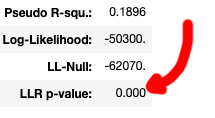

The p-values of all of our features looks pretty good, too. Since we're confident in our overall regression we can move on to check out the **odds ratios**.

In [18]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'name': results.params.index
})
coefs

,coef,odds ratio,name
0,-1.365858,0.255162,Intercept
1,-0.634193,0.530363,C(AGENCY3)[T.L]
2,-0.354048,0.701841,C(AGENCY3)[T.O]
3,1.053720,2.868303,C(AGENCY3)[T.S]
4,0.259407,1.296161,C(SEX)[T.M]
5,-0.288694,0.749242,C(MINORITY)[T.W]
6,-0.313248,0.731068,C(INTOWN)[T.Y]
7,-0.356147,0.700370,C(INSTATE)[T.Y]
8,-0.129495,0.878539,C(DAYNIGHT)[T.night]
9,-0.014586,0.985520,AGE


While these are solid results, the problem is **they don't match the Boston Globe's regression.** Take a look at their output:

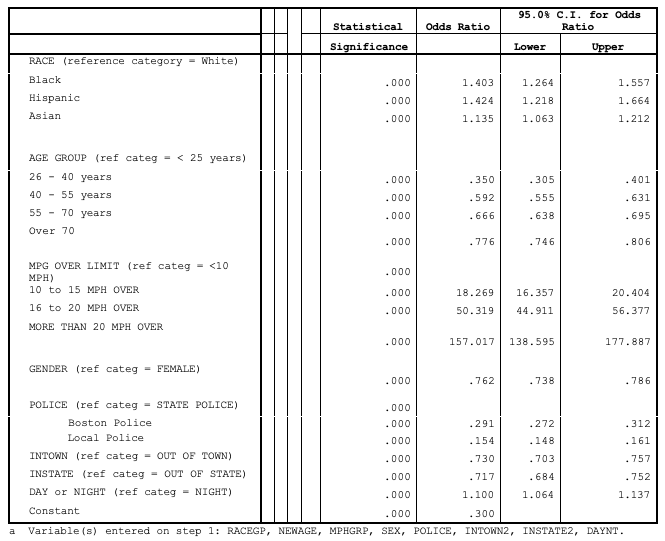

Most notably, they've partitioned both `AGE` and `MPHOVER` into brackets. This allows them to compare each age group against the others, instead of our absurd sweeping statement of "for every year older you are, your odds of getting a ticket goes down by 0.015."

### Feature engineering

Creating new columns that you'll use for regression is **feature engineering**, and it's a very useful way to make more accurate and more interesting comparisons on your dataset.

> Remember when we used [np.divide to convert from 1's of miles to 1000's of miles](https://investigate.ai/regression/linear-regression-part-two/#Calculations-in-formulas)? That was feature engineering, too! This one's just a little more advanced.

Let's bin both `AGE` and `MPHOVER` in the same way that the Globe did.

In [22]:
labels = [
    'under 25',
    '26-39',
    '40-55',
    '56-70',
    'over 70'
]
breaks = [0, 25, 39, 55, 70, 999]
df['age_bin'] = pd.cut(df.AGE, bins=breaks, labels=labels)

# Confirm it worked by looking at a random 10
df[['AGE', 'age_bin']].sample(10)

,AGE,age_bin
27222,30.0,26-39
73995,36.0,26-39
17683,21.0,under 25
54067,17.0,under 25
100250,24.0,under 25
119787,41.0,40-55
133885,44.0,40-55
47583,62.0,56-70
96039,30.0,26-39
164049,38.0,26-39


In [24]:
labels = [
    '<10mph over',
    '10-15mph over',
    '16-20mph over',
    'over 20mph over'
]
breaks = [0, 9, 15, 19, 999]
df['mphover_bin'] = pd.cut(df.MPHOVER, bins=breaks, labels=labels)

# Confirm it worked by looking at a random ten
df[['MPHOVER', 'mphover_bin']].sample(10)

,MPHOVER,mphover_bin
119105,13.0,10-15mph over
118859,13.0,10-15mph over
114502,10.0,10-15mph over
153466,13.0,10-15mph over
105049,17.0,16-20mph over
79856,NaN,NaN
16362,10.0,10-15mph over
61511,10.0,10-15mph over
14570,18.0,16-20mph over
159299,10.0,10-15mph over


Looks good! We've now created the missing features. Next up is tuning our **reference categories** to match what The Globe used.

### Setting reference categories

When you're using `C()` with categorical variables, you always need to set your **reference category** that the odds ratio is calculated against. For example, our regression output listed these two features:

* `C(SEX)[T.M]`, sex when `M` (so reference category is female)
* `C(MINORITY)[T.W]`, minority when `W` (reference category is minority)

The Globe's regression used male as the reference category for sex, and white as the reference category for race. While it's all the same in terms of math, you typically want to set your reference category to be the **most common category**, as it makes more sense to compare things to a baseline. If we had multiple races in our dataset - for example white, Asian, African American, Hispanic - we wouldn't compare everything to the Asian baseline, we'd most probably use white.

If we wanted to do things "right" or "normal," we'd want to check the most common category is in each feature (just ignore the numeric ones).

In [26]:
# If you remember mean/median/mode, mode is the one no
# one ever talks about - it's the most common value!
df.mode()

,TYPE,AGENCY3,SEX,BLACK,ASIAN,HISPANIC,MINORITY,AGE,MPH,MPHOVER,INTOWN,INSTATE,DAYNIGHT,ticketed,age_bin,mphover_bin
0,T,L,M,0.0,0.0,0.0,W,20.0,0,10.0,N,Y,day,1,26-39,10-15mph over


Note that the most common `mphover_bin` is 10-15, but when thinking about "what everything changes in reference to" you might want to use under 10, as it makes the most sense in terms of what you'd end up writing in your article. Arguments could be made both ways, though!

In this case we just want to match what the Globe did, so we'll just copy over their reference categories.

In [27]:
model = smf.logit("""
    ticketed ~ 
        C(AGENCY3, Treatment('S'))
        + C(SEX, Treatment('F'))
        + C(MINORITY, Treatment('W'))
        + C(mphover_bin, Treatment('<10mph over'))
        + C(age_bin, Treatment('under 25'))
        + C(INTOWN, Treatment('N'))
        + C(INTOWN, Treatment('N'))
        """, data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.544180
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ticketed   No. Observations:                89662
Model:                          Logit   Df Residuals:                    89648
Method:                           MLE   Df Model:                           13
Date:                Mon, 30 Dec 2019   Pseudo R-squ.:                  0.2137
Time:                        17:16:30   Log-Likelihood:                -48792.
converged:                       True   LL-Null:                       -62050.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      -1.6859      0.057    -29.807      0.000      -1.797      -1.575
C(AGENCY3, Treatment('S'))[T.B]                                -1.2829      0.035    -36.849      0.000      -1.351      -1.215
C(AGENCY3, Treatment('S'))[T.L]                                -1.8969      0.021    -90.185      0.000      -1.938      -1.856
C(AGENCY3, Treatment('S'))[T.O]                                -1.6323      0.176     -9.278      0.000      -1.977      -1.287
C(SEX, Treatment('F'))[T.M]                                     0.2681      0.016     16.758      0.000       0.237       0.300
C(MINORITY, Treatment('W'))[T.M]                                0.2891      0.024     12.118      0.000       0.242       0.336
C(mphover_bin, Treatment('<10mph over'))[T.10-15mph over]       2.9218      0.056     51.812      0.000       2.811       3.032
C(mphover_bin, Treatment('<10mph over'))[T.16-20mph over]       3.8197      0.059     65.292      0.000       3.705       3.934
C(mphover_bin, Treatment('<10mph over'))[T.over 20mph over]     4.7987      0.060     79.494      0.000       4.680       4.917
C(age_bin, Treatment('under 25'))[T.26-39]                     -0.2371      0.020    -12.055      0.000      -0.276      -0.199
C(age_bin, Treatment('under 25'))[T.40-55]                     -0.3841      0.021    -18.472      0.000      -0.425      -0.343
C(age_bin, Treatment('under 25'))[T.56-70]                     -0.5022      0.033    -15.280      0.000      -0.567      -0.438
C(age_bin, Treatment('under 25'))[T.over 70]                   -1.0228      0.070    -14.650      0.000      -1.160      -0.886
C(INTOWN, Treatment('N'))[T.Y]                                 -0.3679      0.018    -19.952      0.000      -0.404      -0.332
===============================================================================================================================
"""

In [248]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'name': results.params.index
})
coefs

,coef,odds ratio,name
0,-1.685876,0.185282,Intercept
1,-1.282857,0.277244,"C(AGENCY3, Treatment('S'))[T.B]"
2,-1.896896,0.150034,"C(AGENCY3, Treatment('S'))[T.L]"
3,-1.632316,0.195476,"C(AGENCY3, Treatment('S'))[T.O]"
4,0.268142,1.307532,"C(SEX, Treatment('F'))[T.M]"
5,0.289091,1.335213,"C(MINORITY, Treatment('W'))[T.M]"
6,2.921751,18.573780,"C(mphover_bin, Treatment('<10mph over'))[T.10-15mph over]"
7,3.819712,45.591055,"C(mphover_bin, Treatment('<10mph over'))[T.16-20mph over]"
8,4.798733,121.356610,"C(mphover_bin, Treatment('<10mph over'))[T.over 20mph over]"
9,-0.237085,0.788924,"C(age_bin, Treatment('under 25'))[T.26-39]"


In [249]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'name': results.params.index
})
coefs

,coef,odds ratio,name
0,-1.685876,0.185282,Intercept
1,-1.282857,0.277244,"C(AGENCY3, Treatment('S'))[T.B]"
2,-1.896896,0.150034,"C(AGENCY3, Treatment('S'))[T.L]"
3,-1.632316,0.195476,"C(AGENCY3, Treatment('S'))[T.O]"
4,0.268142,1.307532,"C(SEX, Treatment('F'))[T.M]"
5,0.289091,1.335213,"C(MINORITY, Treatment('W'))[T.M]"
6,2.921751,18.573780,"C(mphover_bin, Treatment('<10mph over'))[T.10-15mph over]"
7,3.819712,45.591055,"C(mphover_bin, Treatment('<10mph over'))[T.16-20mph over]"
8,4.798733,121.356610,"C(mphover_bin, Treatment('<10mph over'))[T.over 20mph over]"
9,-0.237085,0.788924,"C(age_bin, Treatment('under 25'))[T.26-39]"


### Turn them binary

Take the statements you want to make and just type them in there

In [194]:
model = smf.logit("""
    got_ticket ~ 
        SEX == 'F'
        + MINORITY == 'M'
        + AGE
        + MPHOVER
        + INTOWN == 'N'
        """, data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.614257
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             got_ticket   No. Observations:                92293
Model:                          Logit   Df Residuals:                    92287
Method:                           MLE   Df Model:                            5
Date:                Sat, 14 Dec 2019   Pseudo R-squ.:                  0.1120
Time:                        00:03:32   Log-Likelihood:                -56692.
converged:                       True   LL-Null:                       -63841.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.0477      0.036    -57.157      0.000      -2.118      -1.977
SEX == 'F'[T.True]         -0.3313      0.015    -22.638      0.000      -0.360      -0.303
MINORITY == 'M'[T.True]     0.3587      0.021     16.791      0.000       0.317       0.401
INTOWN == 'N'[T.True]       0.6169      0.017     37.202      0.000       0.584       0.649
AGE                        -0.0149      0.001    -27.822      0.000      -0.016      -0.014
MPHOVER                     0.1554      0.002     90.607      0.000       0.152       0.159
===========================================================================================
"""

In [195]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'name': results.params.index
})
coefs

,coef,odds ratio,name
0,-2.047714,0.129030,Intercept
1,-0.331280,0.718004,SEX == 'F'[T.True]
2,0.358665,1.431417,MINORITY == 'M'[T.True]
3,0.616885,1.853146,INTOWN == 'N'[T.True]
4,-0.014880,0.985230,AGE
5,0.155384,1.168107,MPHOVER


### Engineer features

You can even get fancier. What about people going VERY fast? They probably get ticketed?

In [198]:
model = smf.logit("""
    got_ticket ~ 
        SEX == 'F'
        + MINORITY == 'M'
        + AGE
        + MPHOVER
        + INTOWN == 'N'
        + MPH > 80
        """, data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.598351
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             got_ticket   No. Observations:                92293
Model:                          Logit   Df Residuals:                    92286
Method:                           MLE   Df Model:                            6
Date:                Sat, 14 Dec 2019   Pseudo R-squ.:                  0.1350
Time:                        00:04:20   Log-Likelihood:                -55224.
converged:                       True   LL-Null:                       -63841.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.7422      0.036    -48.093      0.000      -1.813      -1.671
SEX == 'F'[T.True]         -0.3202      0.015    -21.654      0.000      -0.349      -0.291
MINORITY == 'M'[T.True]     0.3506      0.022     16.291      0.000       0.308       0.393
INTOWN == 'N'[T.True]       0.5355      0.017     32.241      0.000       0.503       0.568
MPH > 80[T.True]            3.0770      0.093     33.002      0.000       2.894       3.260
AGE                        -0.0142      0.001    -26.282      0.000      -0.015      -0.013
MPHOVER                     0.1312      0.002     74.617      0.000       0.128       0.135
===========================================================================================
"""

In [199]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'name': results.params.index
})
coefs

,coef,odds ratio,name
0,-1.742182,0.175138,Intercept
1,-0.320213,0.725995,SEX == 'F'[T.True]
2,0.350607,1.419929,MINORITY == 'M'[T.True]
3,0.535527,1.708348,INTOWN == 'N'[T.True]
4,3.077031,21.693898,MPH > 80[T.True]
5,-0.014202,0.985899,AGE
6,0.131154,1.140143,MPHOVER


### But let's just edit this one sec...

In [213]:
model = smf.logit("""
    got_ticket ~ 
        C(AGENCY3, Treatment('L'))
        + C(SEX, Treatment('M'))
        + C(MINORITY, Treatment('W'))
        + AGE
        + MPHOVER
        + C(INTOWN, Treatment('Y'))
        + MPH > 80
        """, data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.559333
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             got_ticket   No. Observations:                89691
Model:                          Logit   Df Residuals:                    89681
Method:                           MLE   Df Model:                            9
Date:                Sat, 14 Dec 2019   Pseudo R-squ.:                  0.1918
Time:                        00:07:20   Log-Likelihood:                -50167.
converged:                       True   LL-Null:                       -62070.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -2.5833      0.041    -63.180      0.000      -2.663      -2.503
C(AGENCY3, Treatment('L'))[T.B]      0.6214      0.030     20.535      0.000       0.562       0.681
C(AGENCY3, Treatment('L'))[T.O]      0.2703      0.175      1.544      0.123      -0.073       0.614
C(AGENCY3, Treatment('L'))[T.S]      1.5857      0.020     78.111      0.000       1.546       1.626
C(SEX, Treatment('M'))[T.F]         -0.2533      0.016    -16.177      0.000      -0.284      -0.223
C(MINORITY, Treatment('W'))[T.M]     0.2732      0.023     11.712      0.000       0.227       0.319
C(INTOWN, Treatment('Y'))[T.N]       0.3572      0.018     19.730      0.000       0.322       0.393
MPH > 80[T.True]                     1.7589      0.095     18.430      0.000       1.572       1.946
AGE                                 -0.0138      0.001    -24.133      0.000      -0.015      -0.013
MPHOVER                              0.1678      0.002     83.702      0.000       0.164       0.172
====================================================================================================
"""

In [214]:
coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'name': results.params.index
})
coefs

,coef,odds ratio,name
0,-2.583331,0.075522,Intercept
1,0.621379,1.861494,"C(AGENCY3, Treatment('L'))[T.B]"
2,0.270345,1.310416,"C(AGENCY3, Treatment('L'))[T.O]"
3,1.585722,4.882816,"C(AGENCY3, Treatment('L'))[T.S]"
4,-0.253340,0.776204,"C(SEX, Treatment('M'))[T.F]"
5,0.273155,1.314104,"C(MINORITY, Treatment('W'))[T.M]"
6,0.357249,1.429392,"C(INTOWN, Treatment('Y'))[T.N]"
7,1.758940,5.806282,MPH > 80[T.True]
8,-0.013812,0.986282,AGE
9,0.167754,1.182646,MPHOVER
